# NBA Forecast
We will attempt to forecast points scored at the next game for each team. Our focus is on engineering features from time series data.

TODO:
1. define forecast as separate or simultaneous home/away
2. finalize train test
3. train models and evaluate performance
4. show feature importance
5. try Kalman filter
6. add hour of day

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from statsmodels.tsa.stattools import acf
from pandas.plotting import autocorrelation_plot

The new data has gameDateTimeEst which has the exact time of the game. homeScore awayScore replace our target variables

In [4]:
df_games = pd.read_csv('nba_games_2026.csv',index_col=0,low_memory=False)
df_games['game_date'] = pd.to_datetime(df_games['gameDateTimeEst'],format='mixed',utc=True)
print(df_games.columns)
print(df_games['game_date'].max())
df_games.head()

Index(['gameDateTimeEst', 'hometeamCity', 'hometeamName', 'hometeamId',
       'awayteamCity', 'awayteamName', 'awayteamId', 'homeScore', 'awayScore',
       'winner', 'gameType', 'attendance', 'arenaId', 'gameLabel',
       'gameSubLabel', 'seriesGameNumber', 'game_date'],
      dtype='object')
2026-01-18 16:30:00+00:00


,gameDateTimeEst,hometeamCity,hometeamName,hometeamId,awayteamCity,awayteamName,awayteamId,homeScore,awayScore,winner,gameType,attendance,arenaId,gameLabel,gameSubLabel,seriesGameNumber,game_date
gameId,,,,,,,,,,,,,,,,,
22500607,2026-01-18 16:30:00,Los Angeles,Lakers,1610612747,Toronto,Raptors,1610612761,110,93,1610612747,NaN,18997.0,NaN,NaN,NaN,NaN,2026-01-18 16:30:00+00:00
22500606,2026-01-18 16:00:00,Sacramento,Kings,1610612758,Portland,Trail Blazers,1610612757,110,117,1610612757,NaN,16241.0,NaN,NaN,NaN,NaN,2026-01-18 16:00:00+00:00
22500605,2026-01-18 15:00:00,Denver,Nuggets,1610612743,Charlotte,Hornets,1610612766,87,110,1610612766,NaN,19971.0,NaN,NaN,NaN,NaN,2026-01-18 15:00:00+00:00
22500604,2026-01-18 14:00:00,Houston,Rockets,1610612745,New Orleans,Pelicans,1610612740,119,110,1610612745,NaN,18055.0,NaN,NaN,NaN,NaN,2026-01-18 14:00:00+00:00
22500603,2026-01-18 14:00:00,Chicago,Bulls,1610612741,Brooklyn,Nets,1610612751,124,102,1610612741,NaN,19753.0,NaN,NaN,NaN,NaN,2026-01-18 14:00:00+00:00


Capturing Seasonality with Datetime

pd.to_datetime converts series values to datetime objects

dt.day extracts the day of the month (1-31) from a datetime series object like one in Pandas or Polars. 

dt.dayofweek extracts the day of week as an integer (Monday=0, Sunday=6). 

dt.dayofyear extracts the day of year as an integer (1-366). 

dt.isocalendar().week extracts the week of the year, where week 1 contains the first Thursday of the month and the week begins from Monday. This can lead to the first few days of January being assigned to the last week of the previous year.

dt.month extracts the month of the year as an integer (Jan=1, Feb=2,..., Dec=12)

<p align="center">
  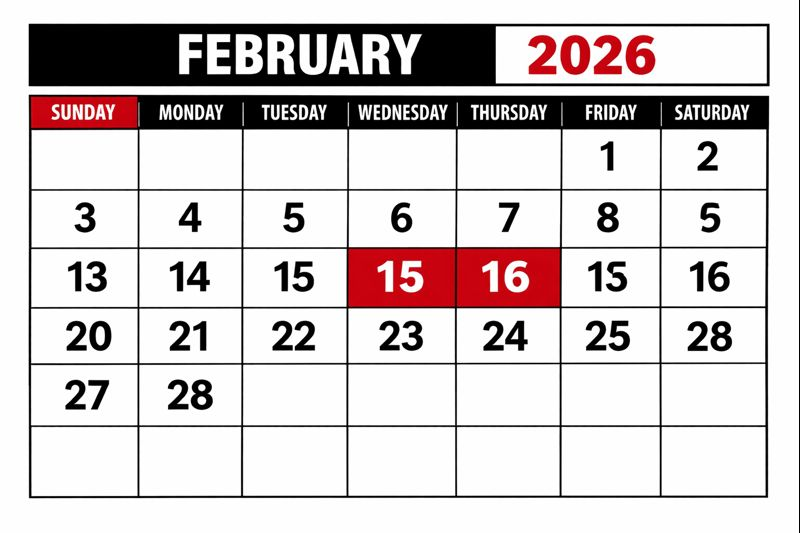
</p>


In [7]:
# Python dt built-ins
dates = pd.to_datetime(df_games['game_date'])
df_games['day_of_week'] = dates.dt.dayofweek
df_games['day_of_month'] = dates.dt.day
df_games['day_of_year'] = dates.dt.dayofyear
df_games['week_of_year'] = dates.dt.isocalendar().week
df_games['month_of_year'] = dates.dt.month
df_games['year'] = dates.dt.year
df_games['is_weekend'] = dates.dt.dayofweek.isin([5, 6]).astype(int)
df_games['is_month_start'] = dates.dt.is_month_start.astype(int)
df_games['is_month_end']   = dates.dt.is_month_end.astype(int)
df_games['is_leap_year']   = dates.dt.is_leap_year.astype(int)

## Cyclical Trigonometry Transformations

<p align="center">
  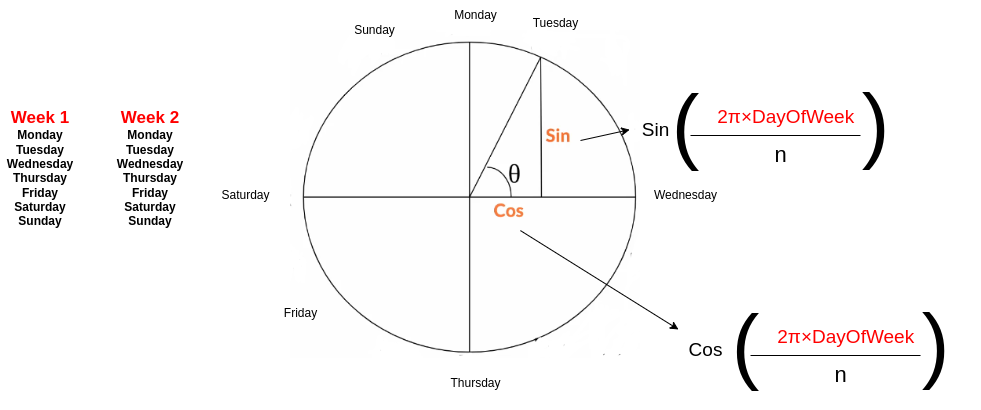
</p>

In [10]:
df_games['sin_day_of_week'] = np.sin(2*np.pi*(df_games['day_of_week'])/7)
df_games['cos_day_of_week'] = np.cos(2*np.pi*(df_games['day_of_week'])/7)

df_games['sin_day_of_month'] = np.sin(2*np.pi*(df_games['day_of_month'])/31)
df_games['cos_day_of_month'] = np.cos(2*np.pi*(df_games['day_of_month'])/31)

df_games['sin_day_of_year'] = np.sin(2*np.pi*(df_games['day_of_year'])/365)
df_games['cos_day_of_year'] = np.cos(2*np.pi*(df_games['day_of_year'])/365)

df_games['sin_week_of_year'] = np.sin(2 * np.pi * df_games['week_of_year'] / 52)
df_games['cos_week_of_year'] = np.cos(2 * np.pi * df_games['week_of_year'] / 52)

df_games['sin_month_of_year'] = np.sin(2 * np.pi * df_games['month_of_year'] / 12)
df_games['cos_month_of_year'] = np.cos(2 * np.pi * df_games['month_of_year'] / 12)

## Seasonality vs NBA Season
What about the cycle within each NBA season? Games are only played October-February, so we can create a feature showing the cyclical nature within that time frame as opposed to 365 days per year.

A season_id matches up with the year the season starts, but seasons may end the following year.

In [13]:
df_games['season_id'] = (df_games['game_date'].dt.year + (df_games['game_date'].dt.month >= 10))
team_season_start = (pd.concat([
        df_games[['game_date','season_id','hometeamName']]
            .rename(columns={'hometeamName':'team'}),
        df_games[['game_date','season_id','awayteamName']]
            .rename(columns={'awayteamName':'team'})]).groupby(['team','season_id'])['game_date'].min())

df_games['home_season_start'] = [
    team_season_start.loc[(t,s)]
    for t,s in zip(df_games['hometeamName'], df_games['season_id'])
]

df_games['away_season_start'] = [
    team_season_start.loc[(t,s)]
    for t,s in zip(df_games['awayteamName'], df_games['season_id'])
]
df_games

,gameDateTimeEst,hometeamCity,hometeamName,hometeamId,awayteamCity,awayteamName,awayteamId,homeScore,awayScore,winner,...,cos_day_of_month,sin_day_of_year,cos_day_of_year,sin_week_of_year,cos_week_of_year,sin_month_of_year,cos_month_of_year,season_id,home_season_start,away_season_start
gameId,,,,,,,,,,,,,,,,,,,,,
22500607,2026-01-18 16:30:00,Los Angeles,Lakers,1610612747,Toronto,Raptors,1610612761,110,93,1610612747,...,-0.874347,0.304921,0.952378,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-03 22:00:00+00:00,2025-10-06 22:00:00+00:00
22500606,2026-01-18 16:00:00,Sacramento,Kings,1610612758,Portland,Trail Blazers,1610612757,110,117,1610612757,...,-0.874347,0.304921,0.952378,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-08 22:00:00+00:00,2025-10-08 22:00:00+00:00
22500605,2026-01-18 15:00:00,Denver,Nuggets,1610612743,Charlotte,Hornets,1610612766,87,110,1610612766,...,-0.874347,0.304921,0.952378,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-04 21:00:00+00:00,2025-10-05 17:00:00+00:00
22500604,2026-01-18 14:00:00,Houston,Rockets,1610612745,New Orleans,Pelicans,1610612740,119,110,1610612745,...,-0.874347,0.304921,0.952378,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-07 00:00:00+00:00,2025-10-03 05:30:00+00:00
22500603,2026-01-18 14:00:00,Chicago,Bulls,1610612741,Brooklyn,Nets,1610612751,124,102,1610612741,...,-0.874347,0.304921,0.952378,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-07 19:00:00+00:00,2025-10-04 20:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24600083,1946-12-08 19:00:00,New York,Knicks,1610612752,Boston,Celtics,1610612738,62,44,1610612752,...,-0.050649,-0.385663,0.922640,-0.354605,0.935016,-2.449294e-16,1.000000,1947,1946-11-30 19:00:00+00:00,1946-11-26 19:00:00+00:00
24600078,1946-12-07 19:00:00,Boston,Celtics,1610612738,New York,Knicks,1610612752,65,90,1610612752,...,0.151428,-0.401488,0.915864,-0.354605,0.935016,-2.449294e-16,1.000000,1947,1946-11-26 19:00:00+00:00,1946-11-30 19:00:00+00:00
24600076,1946-12-05 19:00:00,Philadelphia,Warriors,1610612744,New York,Knicks,1610612752,62,51,1610612744,...,0.528964,-0.432776,0.901502,-0.354605,0.935016,-2.449294e-16,1.000000,1947,1946-11-26 19:00:00+00:00,1946-11-30 19:00:00+00:00


## Season Progress
### Normalization
Should we normalize the days by the season length? NO! That would cause DATA LEAKAGE, because season lengths are not known until a team wins enough games to enter playoffs etc.. Basically the model would know the team makes it to the playoffs before they do, and that is just not possible.

In [15]:
df_games['home_season_days'] = (pd.to_datetime(df_games[
    'game_date']) - pd.to_datetime(df_games['home_season_start'])).dt.days
df_games['away_season_days'] = (pd.to_datetime(df_games[
    'game_date']) - pd.to_datetime(df_games['away_season_start'])).dt.days
df_games['season_progress_diff'] = (df_games[
        'home_season_days'] - df_games['away_season_days'])
df_games[['game_date','hometeamName','awayteamName','home_season_start',	
          'away_season_start',	'home_season_days',	'away_season_days',	'season_progress_diff']].tail()

,game_date,hometeamName,awayteamName,home_season_start,away_season_start,home_season_days,away_season_days,season_progress_diff
gameId,,,,,,,,
24600083,1946-12-08 19:00:00+00:00,Knicks,Celtics,1946-11-30 19:00:00+00:00,1946-11-26 19:00:00+00:00,8,12,-4
24600078,1946-12-07 19:00:00+00:00,Celtics,Knicks,1946-11-26 19:00:00+00:00,1946-11-30 19:00:00+00:00,11,7,4
24600076,1946-12-05 19:00:00+00:00,Warriors,Knicks,1946-11-26 19:00:00+00:00,1946-11-30 19:00:00+00:00,9,5,4
24600063,1946-11-30 19:00:00+00:00,Knicks,Warriors,1946-11-30 19:00:00+00:00,1946-11-26 19:00:00+00:00,0,4,-4
24600052,1946-11-26 19:00:00+00:00,Warriors,Celtics,1946-11-26 19:00:00+00:00,1946-11-26 19:00:00+00:00,0,0,0


In [16]:
# for modeling
# ALL_FEATURES = [col for col in df_games.columns if col not in NON_FEATURE_COLS]


## Lags, Differences, Rolling & Expanding Statistics

What has been happening lately? What is the average behavior over all time? 

TODO:
1. rolling mean std and how to choose the window
2. expanding
3. prune redundant features
4. train random forest
5. evaluate feature importances and model performance

With 72 teams over 75 seasons of data, we can attempt to visualize autocorrerlation by averaging over all team-season possibilities.

In [23]:
print("number of unique teams: ",df_games['hometeamName'].nunique())
print("number of unique seasons: ",df_games['season_id'].nunique())

number of unique teams:  39
number of unique seasons:  80


In [25]:
df_games

,gameDateTimeEst,hometeamCity,hometeamName,hometeamId,awayteamCity,awayteamName,awayteamId,homeScore,awayScore,winner,...,sin_week_of_year,cos_week_of_year,sin_month_of_year,cos_month_of_year,season_id,home_season_start,away_season_start,home_season_days,away_season_days,season_progress_diff
gameId,,,,,,,,,,,,,,,,,,,,,
22500607,2026-01-18 16:30:00,Los Angeles,Lakers,1610612747,Toronto,Raptors,1610612761,110,93,1610612747,...,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-03 22:00:00+00:00,2025-10-06 22:00:00+00:00,106,103,3
22500606,2026-01-18 16:00:00,Sacramento,Kings,1610612758,Portland,Trail Blazers,1610612757,110,117,1610612757,...,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-08 22:00:00+00:00,2025-10-08 22:00:00+00:00,101,101,0
22500605,2026-01-18 15:00:00,Denver,Nuggets,1610612743,Charlotte,Hornets,1610612766,87,110,1610612766,...,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-04 21:00:00+00:00,2025-10-05 17:00:00+00:00,105,104,1
22500604,2026-01-18 14:00:00,Houston,Rockets,1610612745,New Orleans,Pelicans,1610612740,119,110,1610612745,...,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-07 00:00:00+00:00,2025-10-03 05:30:00+00:00,103,107,-4
22500603,2026-01-18 14:00:00,Chicago,Bulls,1610612741,Brooklyn,Nets,1610612751,124,102,1610612741,...,0.354605,0.935016,5.000000e-01,0.866025,2026,2025-10-07 19:00:00+00:00,2025-10-04 20:00:00+00:00,102,105,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24600083,1946-12-08 19:00:00,New York,Knicks,1610612752,Boston,Celtics,1610612738,62,44,1610612752,...,-0.354605,0.935016,-2.449294e-16,1.000000,1947,1946-11-30 19:00:00+00:00,1946-11-26 19:00:00+00:00,8,12,-4
24600078,1946-12-07 19:00:00,Boston,Celtics,1610612738,New York,Knicks,1610612752,65,90,1610612752,...,-0.354605,0.935016,-2.449294e-16,1.000000,1947,1946-11-26 19:00:00+00:00,1946-11-30 19:00:00+00:00,11,7,4
24600076,1946-12-05 19:00:00,Philadelphia,Warriors,1610612744,New York,Knicks,1610612752,62,51,1610612744,...,-0.354605,0.935016,-2.449294e-16,1.000000,1947,1946-11-26 19:00:00+00:00,1946-11-30 19:00:00+00:00,9,5,4


[ 1.          0.02579704  0.00881116  0.00167613 -0.00393836 -0.00803041
 -0.00400262 -0.01269866 -0.01562335 -0.01972162 -0.01103743 -0.01511291
 -0.02156855 -0.02366779 -0.02474731 -0.02102696 -0.02087804 -0.02338521
 -0.01830243 -0.0150428  -0.01928923]


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

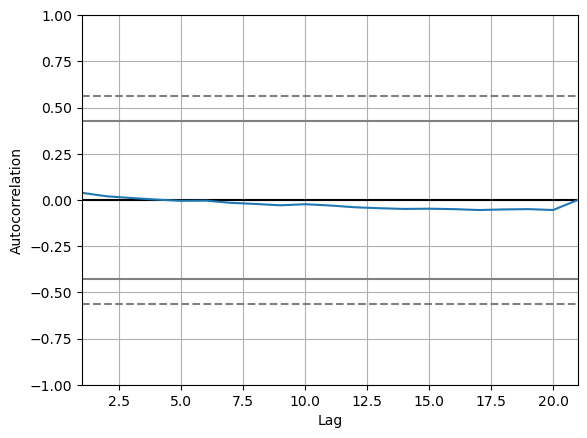

In [27]:
NLAGS = 20
acf_rows = []

for (team, season_id), game in df_games.groupby(['hometeamName', 'season_id']):
    game = game.sort_values('game_date')
    
    y = game['homeScore'].dropna().to_numpy()
    if len(y) < NLAGS + 2:   # too short to estimate reliably
        continue
    
    vals = acf(y, nlags=NLAGS, fft=True)   # returns length NLAGS+1 including lag 0
    acf_rows.append(vals)

acf_mat = np.vstack(acf_rows)
mean_acf = acf_mat.mean(axis=0)

print(mean_acf)  # lag 0..NLAGS
autocorrelation_plot(mean_acf)

In [30]:
team = "Chicago Bulls"
season = 2022

series = (df_games[(df_games['hometeamName'] == team) & \
          (df_games['season_id'] == season)].sort_values('game_date')['homeScore'])
series
# acf_vals = acf(series, nlags=20)
# autocorrelation_plot(acf_vals)

Series([], Name: homeScore, dtype: int64)

Select 2 lags for now. Alternatively, select many lags and perform feature selection via machine learning. 

In [36]:
# Lags
df_games['homeScore_lag_1'] = (df_games.groupby(['hometeamName', 'season_id']) \
        ['homeScore'].shift(1))
df_games['awayScore_lag_1'] = (df_games.groupby(['awayteamName', 'season_id']) \
        ['awayScore'].shift(1))
df_games['homeScore_lag_2'] = (df_games.groupby(['hometeamName', 'season_id']) \
        ['homeScore'].shift(2))
df_games['awayScore_lag_2'] = (df_games.groupby(['awayteamName', 'season_id']) \
        ['awayScore'].shift(2))
# how well do they match up?
df_games['points_lag_1_difference'] = df_games['homeScore_lag_1'] - df_games['awayScore_lag_1']
df_games['points_lag_2_difference'] = df_games['homeScore_lag_2'] - df_games['awayScore_lag_2']

df_games.sort_values(by=['season_id','hometeamName','game_date'])[['season_id','game_date','hometeamName','awayteamName','homeScore',
          'awayScore','homeScore_lag_1','awayScore_lag_1','points_lag_1_difference',
        'homeScore_lag_2','awayScore_lag_2','points_lag_2_difference' ]].tail()

,season_id,game_date,hometeamName,awayteamName,homeScore,awayScore,homeScore_lag_1,awayScore_lag_1,points_lag_1_difference,homeScore_lag_2,awayScore_lag_2,points_lag_2_difference
gameId,,,,,,,,,,,,
22500448,2026,2025-12-29 14:00:00+00:00,Wizards,Suns,101,115,119.0,113.0,6.0,115.0,97.0,18.0
22500477,2026,2026-01-02 14:00:00+00:00,Wizards,Nets,119,99,115.0,98.0,17.0,120.0,105.0,15.0
22500498,2026,2026-01-04 13:00:00+00:00,Wizards,Timberwolves,115,141,120.0,134.0,-14.0,107.0,139.0,-32.0
22500511,2026,2026-01-06 14:00:00+00:00,Wizards,Magic,120,112,107.0,104.0,3.0,NaN,109.0,NaN
22500534,2026,2026-01-09 14:00:00+00:00,Wizards,Pelicans,107,128,NaN,118.0,NaN,NaN,119.0,NaN


## Differences
Capture the recent trends

In [41]:
df_games['home_difference_lags'] = df_games['homeScore_lag_1'] - df_games['homeScore_lag_2']
df_games['away_difference_lags'] = df_games['awayScore_lag_1'] - df_games['awayScore_lag_2']

## Rest Days & Back-to-Back Games

In [44]:
df_games = df_games.sort_values('game_date')
df_games['home_prev_game_date'] = (df_games.groupby(['hometeamName', 'season_id'])['game_date'].shift(1))
df_games['home_rest_days'] = (df_games['game_date'] - df_games['home_prev_game_date']).dt.days
df_games['away_prev_game_date'] = (df_games.groupby(['awayteamName', 'season_id'])['game_date'].shift(1))
df_games['away_rest_days'] = (df_games['game_date'] - df_games['away_prev_game_date']).dt.days
df_games['home_back_to_back'] = (df_games['home_rest_days'] == 1).astype(int)
df_games['away_back_to_back'] = (df_games['away_rest_days'] == 1).astype(int)
df_games['rest_days_diff'] = (df_games['home_rest_days'] - df_games['away_rest_days'])

df_games[['game_date','hometeamName', 'home_rest_days', 'home_back_to_back',
     'awayteamName', 'away_rest_days', 'away_back_to_back','rest_days_diff']].tail(10)

,game_date,hometeamName,home_rest_days,home_back_to_back,awayteamName,away_rest_days,away_back_to_back,rest_days_diff
gameId,,,,,,,,
22500598,2026-01-17 15:00:00+00:00,Spurs,2.0,0,Timberwolves,0.0,0,2.0
22500599,2026-01-17 15:30:00+00:00,Warriors,1.0,1,Hornets,1.0,1,0.0
22500600,2026-01-17 16:00:00+00:00,Nuggets,6.0,0,Wizards,0.0,0,6.0
22500601,2026-01-17 17:00:00+00:00,Trail Blazers,2.0,0,Lakers,5.0,0,-3.0
22500602,2026-01-18 07:00:00+00:00,Grizzlies,6.0,0,Magic,10.0,0,-4.0
22500603,2026-01-18 14:00:00+00:00,Bulls,3.0,0,Nets,3.0,0,0.0
22500604,2026-01-18 14:00:00+00:00,Rockets,1.0,1,Pelicans,2.0,0,-1.0
22500605,2026-01-18 15:00:00+00:00,Nuggets,0.0,0,Hornets,0.0,0,0.0
22500606,2026-01-18 16:00:00+00:00,Kings,1.0,1,Trail Blazers,4.0,0,-3.0


## Rolling Statistics
Recent trends. How has the team score on average over the last 3 days? 

In [47]:
print("maximum number of games ever played in a season: ",
      df_games[['awayteamName','season_id']].value_counts().max())

print("maximum number of games ever played in a season: ",
      df_games[['awayteamName','season_id']].value_counts().min())

maximum number of games ever played in a season:  58
maximum number of games ever played in a season:  1


<Axes: xlabel='count', ylabel='Count'>

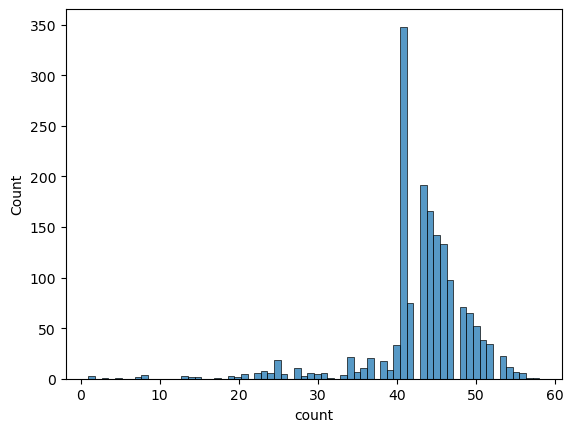

In [49]:
import seaborn as sns
sns.histplot(df_games[['awayteamName','season_id']].value_counts())

In [51]:
print(df_games['home_season_days'].max())
print(df_games['season_id'].value_counts().max())

364
1432


In [53]:
windows = [5, 10, 20]

df_games = df_games.sort_values(['hometeamName', 'season_id', 'game_date'])
# home
for w in windows:
    df_games[f'home_points_rolling_mean_{w}'] = (
        df_games
        .groupby(['hometeamName', 'season_id'])['homeScore']
        .shift(1)
        .rolling(window=w, min_periods=1)
        .mean()
    )

for w in windows:
    df_games[f'home_points_rolling_std_{w}'] = (
        df_games
        .groupby(['hometeamName', 'season_id'])['homeScore']
        .shift(1)
        .rolling(window=w, min_periods=1)
        .std()
    )
df_games['home_points_expanding_mean'] = (df_games.groupby(['hometeamName', 'season_id'])['homeScore'] \
        .shift(1).expanding().mean().reset_index(drop=True))

# away
df_games = df_games.sort_values(['awayteamName', 'season_id', 'game_date'])

for w in windows:
    df_games[f'away_points_rolling_mean_{w}'] = (
        df_games
        .groupby(['awayteamName', 'season_id'])['awayScore']
        .shift(1)
        .rolling(window=w, min_periods=1)
        .mean()
    )


for w in windows:
    df_games[f'away_points_rolling_std_{w}'] = (
        df_games
        .groupby(['awayteamName', 'season_id'])['awayScore']
        .shift(1)
        .rolling(window=w, min_periods=1)
        .std()
    )
df_games['away_points_expanding_mean'] = (df_games.groupby(['awayteamName', 'season_id'])['awayScore'] \
        .shift(1).expanding().mean().reset_index(drop=True))

df_games

,gameDateTimeEst,hometeamCity,hometeamName,hometeamId,awayteamCity,awayteamName,awayteamId,homeScore,awayScore,winner,...,home_points_rolling_std_10,home_points_rolling_std_20,home_points_expanding_mean,away_points_rolling_mean_5,away_points_rolling_mean_10,away_points_rolling_mean_20,away_points_rolling_std_5,away_points_rolling_std_10,away_points_rolling_std_20,away_points_expanding_mean
gameId,,,,,,,,,,,,,,,,,,,,,
26300001,1963-10-16 19:00:00,Detroit,Pistons,1610612765,Philadelphia,76ers,1610612755,115,117,1610612755,...,8.790778,8.989272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26300019,1963-10-26 19:00:00,New York,Knicks,1610612752,Philadelphia,76ers,1610612755,109,101,1610612752,...,11.185308,10.638395,NaN,117.000000,117.000000,117.000000,NaN,NaN,NaN,NaN
26300024,1963-10-30 19:00:00,Baltimore,Bullets,1610612764,Philadelphia,76ers,1610612755,108,111,1610612755,...,8.689074,12.720109,NaN,109.000000,109.000000,109.000000,11.313708,11.313708,11.313708,NaN
26300033,1963-11-02 19:00:00,St. Louis,Hawks,1610612737,Philadelphia,76ers,1610612755,128,99,1610612737,...,12.755173,12.674974,NaN,109.666667,109.666667,109.666667,8.082904,8.082904,8.082904,NaN
26300034,1963-11-03 19:00:00,Cincinnati,Royals,1610612758,Philadelphia,76ers,1610612755,95,93,1610612758,...,12.747549,14.423016,NaN,107.000000,107.000000,107.000000,8.485281,8.485281,8.485281,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26200300,1963-02-22 19:00:00,St. Louis,Hawks,1610612737,Chicago,Zephyrs,1610612764,115,98,1610612737,...,12.470409,12.729989,NaN,106.000000,109.700000,108.650000,9.539392,9.956014,9.326109,NaN
26200316,1963-02-28 19:00:00,Detroit,Pistons,1610612765,Chicago,Zephyrs,1610612764,112,104,1610612765,...,9.589346,11.937887,NaN,104.200000,107.900000,108.550000,10.134101,10.311267,9.433842,NaN
26200325,1963-03-03 19:00:00,St. Louis,Hawks,1610612737,Chicago,Zephyrs,1610612764,104,97,1610612737,...,12.972192,10.622221,NaN,104.000000,105.700000,107.600000,10.124228,8.138386,8.840100,NaN


# Forecasting 
## Machine Learning vs Traditional Time Series
ARIMA: one team at a time, standard when compute power was low in the early 2000's
Random Forest: Entire dataset over all teams and all time, more compute, better results

## Train-Test Split
How do we split multiple time series data for forecasting?In this case, we want to be aware of NBA play-offs schedules. We don't want our model to realize that February is full of high performing teams only and default to very high values. We need a sophisticated split that accounts for teams that do not make it to the play-offs.

Typical ML split: 80% for training, 20% for testing

Let's take 80% of each team's season games as training data and the remainder in testing.

In [63]:
team_games = (
    pd.concat([
        df_games[['game_date','season_id','hometeamName']]
            .rename(columns={'hometeamName':'team'}),
        df_games[['game_date','season_id','awayteamName']]
            .rename(columns={'awayteamName':'team'})
    ])
    .sort_values(['team','season_id','game_date'])
)

team_games['game_number'] = (
    team_games.groupby(['team','season_id']).cumcount() + 1
)
#  Data Leakage Warning: do not use games_in_season in training as it can only be known after the event of interest.
team_games['games_in_season'] = (
    team_games.groupby(['team','season_id'])['game_number']
    .transform('max')
)

team_games['is_train'] = (
    team_games['game_number']
    <= 0.8 * team_games['games_in_season']
)

team_games.head()

,game_date,season_id,team,game_number,games_in_season,is_train
gameId,,,,,,
26300001,1963-10-16 19:00:00+00:00,1964,76ers,1,85,True
26300006,1963-10-19 19:00:00+00:00,1964,76ers,2,85,True
26300015,1963-10-25 19:00:00+00:00,1964,76ers,3,85,True
26300019,1963-10-26 19:00:00+00:00,1964,76ers,4,85,True
26300024,1963-10-30 19:00:00+00:00,1964,76ers,5,85,True


In [67]:
team_games['is_train'].value_counts(normalize=True)

is_train
True     0.795113
False    0.204887
Name: proportion, dtype: float64

In [74]:
df_games.columns


dropped_feature_list = ['gameDateTimeEst', 'hometeamCity', 'hometeamName', 'hometeamId',
       'awayteamCity', 'awayteamName', 'awayteamId', 'homeScore', 'awayScore',
       'winner', 'gameType', 'attendance', 'arenaId', 'gameLabel',
       'gameSubLabel', 'seriesGameNumber', 'game_date', ]
           

Y_output_feature_list = ['homeScore', 'awayScore']         
X_input_feature_list = ['day_of_week',
       'day_of_month', 'day_of_year', 'week_of_year', 'month_of_year', 'year',
       'is_weekend', 'is_month_start', 'is_month_end', 'is_leap_year',
       'sin_day_of_week', 'cos_day_of_week', 'sin_day_of_month',
       'cos_day_of_month', 'sin_day_of_year', 'cos_day_of_year',
       'sin_week_of_year', 'cos_week_of_year', 'sin_month_of_year',
       'cos_month_of_year', 'season_id', 'home_season_start',
       'away_season_start', 'home_season_days', 'away_season_days',
       'season_progress_diff', 'homeScore_lag_1', 'awayScore_lag_1',
       'homeScore_lag_2', 'awayScore_lag_2', 'points_lag_1_difference',
       'points_lag_2_difference', 'home_difference_lags',
       'away_difference_lags', 'home_prev_game_date', 'home_rest_days',
       'away_prev_game_date', 'away_rest_days', 'home_back_to_back',
       'away_back_to_back', 'rest_days_diff', 'home_points_rolling_mean_5',
       'home_points_rolling_mean_10', 'home_points_rolling_mean_20',
       'home_points_rolling_std_5', 'home_points_rolling_std_10',
       'home_points_rolling_std_20', 'home_points_expanding_mean',
       'away_points_rolling_mean_5', 'away_points_rolling_mean_10',
       'away_points_rolling_mean_20', 'away_points_rolling_std_5',
       'away_points_rolling_std_10', 'away_points_rolling_std_20',
       'away_points_expanding_mean']

In [ ]:
# X_train = team_gamesteam_games['is_train']==True]
# X_train = team_gamesteam_games['is_train']==True]

# Random Forest
Performs feature selection via randomly selecting features for each tree and optimizing GINI impurity + overall variance at leaf nodes.

In [ ]:
boosted_tree_regressor_model = GradientBoostingRegressor(random_state=7)
forecasted_values = boosted_tree_regressor_model.fit(team1_X_train, team1_y_train)
forecasted_values=team1_reg.predict(team1_X_test)

In [ ]:
GradientBoostingRegressor(random_state=7)
    team1_reg.fit(team1_X_train, team1_y_train)
    team1_preds=team1_reg.predict(team1_X_test)

In [ ]:
def train_test_split(team_df,cut_date):
    train_df=team_df[team_df['game_date']<=cut_date]
    test_df=team_df[team_df['game_date']>cut_date]
    return train_df, test_df
def x_y_train(train_df,test_df):
    X_train=train_df[['pts_scored','wl','opp_score','location']]
    y_train=train_df['next_game_points_scored']
    X_test=test_df[['pts_scored','wl','opp_score','location']]
    y_test=test_df['next_game_points_scored']
    return  X_train, y_train, X_test, y_test

In [38]:
def gimme_data(df_games,team):
    home_games=df_games[df_games['team_name_home']==team][[
        'game_id', 'game_date','team_name_home','pts_home','wl_home',
        'team_name_away','pts_away']]
    home_games['ha']='home'
    home_games=home_games.rename(columns={'team_name_home':'team_name','pts_home':'pts_scored','wl_home':'wl',
                                         'pts_away':'opp_score','team_name_away':'opp_team'})

    # home_games.rename(columns={'team_name_home','team_name'})
    away_games_df=df_games[df_games['team_name_away']==team][[
        'game_id', 'game_date','team_name_away','pts_away','wl_away','team_name_home','pts_home']]
    away_games_df['ha']='away'
    away_games_df=away_games_df.rename(columns={'team_name_away':'team_name',
                                                'pts_away':'pts_scored','wl_away':'wl',
                                               'pts_home':'opp_score','team_name_home':'opp_team'})
    one_team=pd.merge(away_games_df, home_games, how="outer").sort_values(by='game_date',ignore_index=True)
    one_team.insert(3,'next_game_points_scored',one_team['pts_scored'].shift(-1))
    one_team['wl']=one_team['wl'].replace(['W', 'L'],[1,0])
    one_team['ha']=one_team['ha'].replace(['home', 'away'],[1,0])
    return one_team

In [39]:
teams=list(pd.unique(df_games['team_name_home']))
df1=gimme_data(df_games,team=teams[0])
for team in teams[1:]:
    df=gimme_data(df_games,team=team)
    df1=pd.concat([df1, df], ignore_index=True, axis=0) 

In [44]:
df1[df1['team_name']=='Chicago Bulls'].head()

,game_id,game_date,team_name,next_game_points_scored,pts_scored,wl,opp_team,opp_score,ha
40647,0026600005,1966-10-15 00:00:00,Chicago Bulls,119.0,104,1.0,St. Louis Hawks,97,0
40648,0026600007,1966-10-18 00:00:00,Chicago Bulls,134.0,119,1.0,San Francisco Warriors,116,1
40649,0026600009,1966-10-19 00:00:00,Chicago Bulls,111.0,134,1.0,Los Angeles Lakers,124,1
40650,0026600011,1966-10-20 00:00:00,Chicago Bulls,108.0,111,0.0,San Francisco Warriors,121,0
40651,0026600015,1966-10-21 00:00:00,Chicago Bulls,105.0,108,1.0,Los Angeles Lakers,101,0


In [41]:
bulls=gimme_data(df_games,team='Chicago Bulls')
wash=gimme_data(df_games,team='Washington Wizards')
heat=gimme_data(df_games,team='Miami Heat')
bulls.tail()

,game_id,game_date,team_name,next_game_points_scored,pts_scored,wl,opp_team,opp_score,ha
4408,0022200863,2023-02-13 00:00:00,Chicago Bulls,113.0,91,0,Orlando Magic,100,1
4409,0022200874,2023-02-15 00:00:00,Chicago Bulls,100.0,113,0,Indiana Pacers,117,0
4410,0022200883,2023-02-16 00:00:00,Chicago Bulls,131.0,100,0,Milwaukee Bucks,112,1
4411,0022200900,2023-02-24 00:00:00,Chicago Bulls,102.0,131,1,Brooklyn Nets,87,1
4412,0022200912,2023-02-26 00:00:00,Chicago Bulls,NaN,102,1,Washington Wizards,82,1


In [9]:
wash.tail()

,game_id,game_date,team_name,next_game_points_scored,pts_scored,wl,opp_team,opp_score,location,opps_next_game_points
1955,0022200866,2023-02-13 00:00:00,Washington Wizards,126.0,126,0,Golden State Warriors,135,0,101.0
1956,0022200872,2023-02-14 00:00:00,Washington Wizards,114.0,126,1,Portland Trail Blazers,101,0,106.0
1957,0022200884,2023-02-16 00:00:00,Washington Wizards,109.0,114,1,Minnesota Timberwolves,106,0,115.0
1958,0022200895,2023-02-24 00:00:00,Washington Wizards,82.0,109,0,New York Knicks,115,1,102.0
1959,0022200912,2023-02-26 00:00:00,Washington Wizards,NaN,82,0,Chicago Bulls,102,0,NaN


In [12]:
def train_test_split(team_df,cut_date):
    train_df=team_df[team_df['game_date']<=cut_date]
    test_df=team_df[team_df['game_date']>cut_date]
    return train_df, test_df
def x_y_train(train_df,test_df):
    X_train=train_df[['pts_scored','wl','opp_score','location']]
    y_train=train_df['next_game_points_scored']
    X_test=test_df[['pts_scored','wl','opp_score','location']]
    y_test=test_df['next_game_points_scored']
    return  X_train, y_train, X_test, y_test
def one_team_forecast(team_1,cut_date):
    team1_train_df, team1_test_df = train_test_split(team_df=team_1,cut_date=cut_date)
    team1_X_train, team1_y_train, team1_X_test, team1_y_test = x_y_train(team1_train_df,team1_test_df)
    team1_reg = GradientBoostingRegressor(random_state=7)
    team1_reg.fit(team1_X_train, team1_y_train)
    team1_preds=team1_reg.predict(team1_X_test)
    team1_test_df.insert(4,'forecast_next_game',team1_preds)
    return team1_test_df

In [13]:
one_team_forecast(team_1=bulls,cut_date='2023-02-24')

,game_id,game_date,team_name,next_game_points_scored,forecast_next_game,pts_scored,wl,opp_team,opp_score,location,opps_next_game_points
4411,0022200900,2023-02-24 00:00:00,Chicago Bulls,102.0,108.572427,131,1,Brooklyn Nets,87,1,82.0
4412,0022200912,2023-02-26 00:00:00,Chicago Bulls,NaN,101.243712,102,1,Washington Wizards,82,1,NaN


In [14]:
one_team_forecast(team_1=wash,cut_date='2023-02-12')

,game_id,game_date,team_name,next_game_points_scored,forecast_next_game,pts_scored,wl,opp_team,opp_score,location,opps_next_game_points
1955,0022200866,2023-02-13 00:00:00,Washington Wizards,126.0,114.265546,126,0,Golden State Warriors,135,0,101.0
1956,0022200872,2023-02-14 00:00:00,Washington Wizards,114.0,105.268862,126,1,Portland Trail Blazers,101,0,106.0
1957,0022200884,2023-02-16 00:00:00,Washington Wizards,109.0,107.646598,114,1,Minnesota Timberwolves,106,0,115.0
1958,0022200895,2023-02-24 00:00:00,Washington Wizards,82.0,105.816881,109,0,New York Knicks,115,1,102.0
1959,0022200912,2023-02-26 00:00:00,Washington Wizards,NaN,93.582979,82,0,Chicago Bulls,102,0,NaN
